In [1]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from utils import featre_to_tick, get_colors_dict
import argparse
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
# keep only columns that are related to mutations
gene_expr_all = pd.read_csv("gene/data/PORPOISE_data_matched.csv")
sel_cols = [col for col in gene_expr_all.columns if "_mut" in col]
gene_expr_all = gene_expr_all[['type', 'case_id', 'slide_id'] + sel_cols]

sel_cols = [col for col in gene_expr_all.columns if "_mut" in col]
col_rename_dict = {col: col.split("_")[0] for col in sel_cols}
gene_expr_all = gene_expr_all.rename(columns=col_rename_dict)

/tmp/ipykernel_2006515/658572904.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_expr_all = pd.read_csv("gene/data/PORPOISE_data_matched.csv")


In [3]:
selected_feats = [
"mit_wsi_count",
"mit_hotspot_count",
"mit_nodeDegrees_mean",
"mit_nodeDegrees_max",
"mit_nodeDegrees_std",
"mit_clusterCoff_mean",
"mit_clusterCoff_std",
"mit_clusterCoff_perc10",
"mit_clusterCoff_perc80",
"mit_cenDegree_mean",
"mit_cenDegree_std",
"mit_cenCloseness_max",
"mit_cenEigen_mean",
"mit_cenEigen_max",
"mit_cenEigen_std",
"mit_cenHarmonic_mean",
"mit_cenHarmonic_std",
]
mitosis_feats = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv')
mitosis_feats = mitosis_feats[["bcr_patient_barcode", "type"]+selected_feats]
mitosis_feats.columns = [featre_to_tick(col) if col not in ["bcr_patient_barcode", "type"] else col for col in mitosis_feats.columns]
mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")

In [4]:
gene_expr_all["type"].unique()

array(['LUSC', 'STAD', 'SKCM', 'BRCA', 'LUAD', 'COADREAD', 'HNSC', 'PAAD',
       'UCEC', 'GBM', 'LGG', 'KIRC', 'BLCA', 'LIHC', 'KIRP'], dtype=object)

In [200]:
cancer_type = "GBM"
mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"]==cancer_type]
gene_exp_cancer = gene_expr_all[gene_expr_all["type"]==cancer_type]


# drop missing mutations
gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")
# drop cases with all mutations as Nan


# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['case_id']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_exp_cancer[gene_exp_cancer['case_id'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='case_id')

## Sort the dataframes based on 'case_name'
df1_common = df1_common.sort_values('bcr_patient_barcode')
df2_common = df2_common.sort_values('case_id')

X = df1_common.drop(columns=["bcr_patient_barcode", "type"]).reset_index(drop=True)
Y = df2_common.drop(columns=['case_id', 'type', 'slide_id']).reset_index(drop=True)

Y = Y[Y.sum(axis=0).index[Y.sum(axis=0)>5]]
Y = Y[Y.std(axis=0).index[Y.std(axis=0)!=0]]


In [199]:
Y.std(axis=0).index[Y.std(axis=0)!=0]

Index(['FLG', 'HMCN1', 'MUC16', 'NF1', 'PIK3CA', 'PTEN', 'RYR2', 'TP53', 'TTN',
       'ATRX', 'CIC', 'EGFR', 'PIK3R1', 'FUBP1', 'IDH1'],
      dtype='object')

In [201]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

def auc_association_matrix(X: pd.DataFrame, Y: pd.DataFrame) -> pd.DataFrame:
    # Drop rows with NaN values in Y and align the indices
    non_nan_indices = ~Y.isna().any(axis=1)
    X_clean = X.loc[non_nan_indices]
    Y_clean = Y.loc[non_nan_indices]
    
    # Standardize the columns of X to the 0-1 range
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
    
    # Initialize an empty DataFrame for the AUC association matrix
    auc_matrix = pd.DataFrame(index=X.columns, columns=Y.columns)
    
    # Iterate over each combination of columns from X and Y
    for x_col in X.columns:
        for y_col in Y.columns:
            # Compute the AUC score for the current pair of columns
            auc_score = roc_auc_score(Y_clean[y_col], X_scaled[x_col])
            # Store the AUC score in the matrix
            auc_matrix.at[x_col, y_col] = 2*(auc_score - 0.5)
    
    return auc_matrix.astype(float).T

auc_matrix = auc_association_matrix(X, Y)
# drop duplicated mutations
auc_matrix = auc_matrix.loc[~auc_matrix.index.duplicated(keep='first')]

In [202]:
ref_auc = auc_matrix.copy()

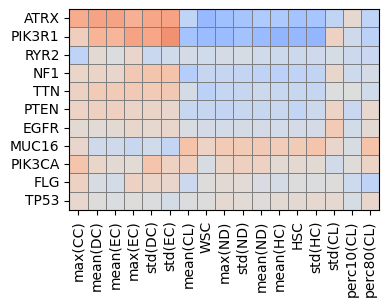

In [203]:
from scipy.cluster.hierarchy import linkage, leaves_list

auc_matrix = ref_auc.copy()
if len(auc_matrix) > 20:
    aucs_sorted = auc_matrix.abs().max(axis=1).sort_values(ascending=False)
    max_ass = aucs_sorted.head(20).index
    auc_matrix = auc_matrix.loc[list(max_ass), :]

# Perform hierarchical clustering
row_linkage = linkage(auc_matrix, method='ward')
col_linkage = linkage(auc_matrix.T, method='ward')

# Get the order of rows and columns based on clustering
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the data matrix
auc_matrix_reordered = auc_matrix.iloc[:, col_order].iloc[row_order, :]
# Plot the heatmap with reordered data and customization
plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(auc_matrix_reordered, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                      linewidths=0.5, linecolor='gray', square=True,
                      cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'})


for _, spine in heatmap.spines.items():
    spine.set_visible(True)

# # # Adjust colorbar label
# colorbar = heatmap.collections[0].colorbar
# colorbar.set_label('Scaled AUC', rotation=270, labelpad=15)
# plt.xticks(rotation=30, ha='right')
plt.show()

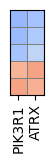

In [204]:
# Sort the DataFrame rows and columns alphabetically
# auc_matrix_sorted = auc_matrix.sort_index(axis=0)#.sort_index(axis=1)
# auc_matrix_sorted = auc_matrix_sorted[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "max(EC)"]] # select only desired features

auc_matrix_reordered = auc_matrix_reordered[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "max(EC)"]] 

if len(auc_matrix_reordered) > 5:
    max_ass = auc_matrix_reordered.abs().max(axis=1).sort_values(ascending=False)
    max_ass = max_ass[max_ass>0.3]
    max_ass = max_ass.head(5).index
    auc_matrix_reordered = auc_matrix_reordered.loc[list(max_ass), :]

# Plot the heatmap with reordered data and customization
plt.figure(figsize=(1.1, 1.1))
heatmap = sns.heatmap(auc_matrix_reordered.T, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                      linewidths=0.5, linecolor='gray', square=True,
                      cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'})


for _, spine in heatmap.spines.items():
    spine.set_visible(True)

plt.yticks([])
# # # Adjust colorbar label
# colorbar = heatmap.collections[0].colorbar
# colorbar.set_label('Scaled AUC', rotation=270, labelpad=15)
# plt.xticks(rotation=30, ha='right')
plt.show()

/tmp/ipykernel_2006515/1689792988.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


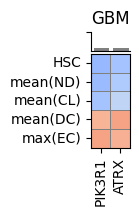

In [205]:
count_ones = Y[auc_matrix_reordered.index].mean(axis=0)

# Calculate figure size dynamically based on the number of columns (heatmap cells width)
n_cols = auc_matrix_reordered.shape[0]
cell_size = 0.25  # size of each cell in inches
fig_width = n_cols * cell_size
fig_height = 1.5  # fixed height for consistency

# Create a barplot above the heatmap
fig, (ax_bar, ax_heatmap) = plt.subplots(2, 1, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios': [1, 5], 'hspace': 0.05})
# fig.subplots_adjust(hspace=-1.1)

# Barplot
sns.barplot(x=count_ones.index, y=count_ones.values, ax=ax_bar, color='gray', width=0.5*cell_size)
ax_bar.set_xticklabels([])
ax_bar.set_xticks([])
ax_bar.set_xlabel('')
ax_bar.set_ylabel('')
ax_bar.set_title(cancer_type)  # example title, adjust as needed
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.set_xlim(-0.2, n_cols - 0.2)
ax_bar.set_ylim(0, 0.5)
ax_bar.set_yticks([0.5])
ax_bar.set_yticklabels([])

# Adjust bar width
for bar in ax_bar.patches:
    bar.set_width(0.8)

# Heatmap
sns.heatmap(auc_matrix_reordered.T, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
            linewidths=0.5, linecolor='gray', xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'}, ax=ax_heatmap)

for _, spine in ax_heatmap.spines.items():
    spine.set_visible(True)

# plt.yticks([])

plt.tight_layout()
plt.show()


In [206]:
ci = 0
[0.5] if ci==0 else []

[0.5]

In [185]:
Y[(Y.std(axis=0)!=0).index]

,DMD,DST,FLG,HMCN1,KMT2C,MUC16,NCOR1,NEB,PIK3CA,PTEN,...,SPTA1,SYNE1,TP53,TTN,USH2A,ZFHX4,RAS,CDH1,GATA3,MAP3K1
0,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1,0.0,1.0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0.0,1.0,0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1,0.0,0.0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0,0.0
944,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0,0.0
945,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,1,1.0,0.0,0.0
946,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0,0.0


In [173]:
import pandas as pd
import scipy.stats as stats

# Example data
data = {
    'phenotype': [0, 1.2, 2.4, 4.4, 6.7, 0.5, 2.7, 1.8, 4.1, 6.5],
    'CNV':       [-2, -1, 0, 1, 2, -2, 0, -1, 1, 2]
}
df = pd.DataFrame(data)

# Group data by CNV levels
groups = df.groupby('CNV')['phenotype'].apply(list)

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in the phenotype means across CNV levels.")
else:
    print("There is no significant difference in the phenotype means across CNV levels.")


F-statistic: 147.78915662650635
p-value: 2.2412099376727877e-05
There is a significant difference in the phenotype means across CNV levels.


In [158]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['phenotype'], groups=df['CNV'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    -2     -1     1.25 0.0371  0.0943 2.4057   True
    -2      0      2.3 0.0027  1.1443 3.4557   True
    -2      1      4.0 0.0002  2.8443 5.1557   True
    -2      2     6.35    0.0  5.1943 7.5057   True
    -1      0     1.05 0.0709 -0.1057 2.2057  False
    -1      1     2.75 0.0012  1.5943 3.9057   True
    -1      2      5.1 0.0001  3.9443 6.2557   True
     0      1      1.7 0.0104  0.5443 2.8557   True
     0      2     4.05 0.0002  2.8943 5.2057   True
     1      2     2.35 0.0024  1.1943 3.5057   True
---------------------------------------------------


In [30]:
# fix gbm and lgg being one
mit_feats_gbm_lgg = mitosis_feats[mitosis_feats["type"].isin(["LGG"])]

In [31]:
# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mit_feats_gbm_lgg['bcr_patient_barcode']).intersection(set(gene_expr_all['case_id']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats[mitosis_feats['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_expr_all[gene_expr_all['case_id'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='case_id')

In [32]:
gene_expr_all["type"][list(df2_common.index)] = "LGG"

/tmp/ipykernel_3678432/1945969055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_expr_all["type"][list(df2_common.index)] = "LGG"


In [34]:
# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mitosis_feats['bcr_patient_barcode']).intersection(set(gene_expr_all['case_id']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats[mitosis_feats['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_expr_all[gene_expr_all['case_id'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='case_id')

In [35]:
df2_common.to_csv("PORPOISE_data_matched.csv", index=None)